# Multi-label Classification

Multi-label classification is a variant of the classification problem where multiple labels may be assigned to each instance. Multi-label classification is a generalization of [multiclass classification](https://en.wikipedia.org/wiki/Multiclass_classification), which is the single-label problem of categorizing instances into precisely one of more than two classes. However, in the multi-label problem there is no constraint on how many of the classes the instance can be assigned to.

Formally, multi-label classification is the problem of finding a model that maps inputs **x** to binary vectors **y** (assigning a value of `0` or `1` for each element (label) in **y**).

## Dataset

For better understanding, let us start practicing on a multi-label dataset. You can find a real-world data set from the [repository](http://www.uco.es/kdis/mllresources/) provided by MULAN package. These datasets are present in ARFF format.

We will use the [**emotions**](http://www.uco.es/kdis/mllresources/#EmotionsDesc) dataset. This dataset contains 593 different songs.

- Rhythmic Features: The rhythmic features were derived by extracting periodic changes from a beat histogram. An algorithm that identifies peaks using autocorrelation was implemented by the authors. They selected the two highest peaks and computed their amplitudes, their BMPs (beats per minute) and the high-to-low ratio of their BPMs. In addition, 3 features were calculated by summing the histogram bins between 40-90, 90-140 and 140-250 BPMs respectively. The whole process led to a total of 8 rhythmic features.

- Timbre Features: Mel Frequency Cepstral Coefficients (MFCCs) are used for speech recognition and music modeling. To derive MFCCs features, the signal was divided into frames and the amplitude spectrum was calculated for each frame. Next, its logarithm was taken and converted to Mel scale. Finally, the discrete cosine transform was implemented. They selected the first 13 MFCCs. Another set of 3 features that relate to timbre textures were extracted from the Short-Term Fourier Transform (FFT): Spectral centroid, spectral rolloff and spectral flux. For each of the 16 aforementioned features (13 MFCCs, 3 FFT) they calculated the mean, standard deviation (std), mean standard deviation (mean std) and standard deviation of standard deviation (std std) over all frames. This led to a total of 64 timbre features.

- Emotion Labels: These are the targets of the classification, there are 6 classes designed so that a song can represent more than one emotion. So making the problem a Multi-Label one.

The paper related to the production of this dataset is available at: https://ismir2008.ismir.net/papers/ISMIR2008_275.pdf

In [1]:
from typing import Tuple
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff 

def read(file='emotions.arff') -> Tuple[pd.DataFrame, pd.DataFrame]:
  """
  Read the .arff file and return the features and labels.

  Parameters
  ----------
  file: str, default=emotions.arff
    File name to be read.
  
  Returns
  -------
  X: pandas.DataFrame
    The features dataframe.
  y: pandas.DataFrame
    The labels dataframe.
  """
  raw_data = loadarff(file)
  df = pd.DataFrame(raw_data[0])
  X = df.iloc[:, : -6]
  y = df.iloc[:, -6 :].astype(int)
  return X, y

X, y = read()
print(f'Shape X: {X.shape}')
print(f'Shape y: {y.shape}')

Shape X: (593, 72)
Shape y: (593, 6)


## Problem Transformation

It is one of the techniques for solving a multi-label classification problem. In this method, the multi-label problem is tranformed into a single-label problem(s).

This method can be carried out in three different ways as:

1.   Binary Relevance
2.   Classifier Chains
3.   Label Powerset



### Binary Relevance
This is the simplest technique, which basically treats each label as a separate single class classification problem.

For example, let us consider a case as shown below. We have the data set like this, where X is the independent feature and Y’s are the target variable.

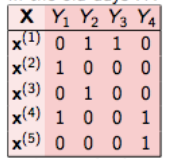

In binary relevance, this problem is broken into 4 different single class classification problems as shown in the figure below.

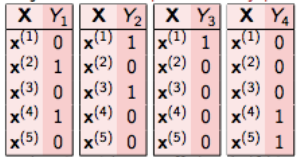

### Classifier Chains
In this, the first classifier is trained just on the input data and then each next classifier is trained on the input space and all the previous classifiers in the chain.  

Let’s try to understand this by an example. In the dataset given below, we have **X** as the input space and **Y**’s as the labels.

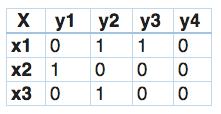

In classifier chains, this problem would be transformed into 4 different single label problems, just like shown below. Here yellow colored is the input space and the white part represent the target variable.

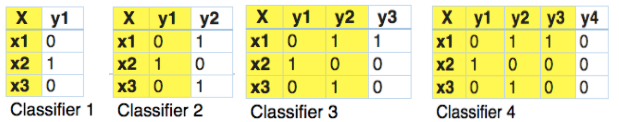

This is quite similar to binary relevance, the only difference being it forms chains in order to preserve label correlation.

## Exercise

Implement the Binary Relevance (BR) and Classifier Chains (CC) method using [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) as a base learner. Determine the performance of these methods on the above emotions dataset. More specifically, provide an estimation of the Hamming loss and subset $0/1$ loss by averaging the performance estimates of 5 repetitions of a 2-fold cross validation experiment.

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.model_selection import cross_val_score

class BinaryRelevance(ClassifierMixin, BaseEstimator):
  """
  Implementation of Binary Relevance method for Multi-label classification.

  Paramters
  ---------
  base_clf: default=LogisticRegression
    The base classifier to be used.
  clf_params: dict
    The classifier parameters used in the constructor of the base learner.

  Attributes
  ----------
  classifiers: list
    A list of all base learner classifiers used to fit data in binary relevance manner.
  """
  def __init__(self, base_clf=LogisticRegression, clf_params=None):
    self.base_clf = base_clf
    self.clf_params = clf_params
    self.classifiers = []
      
  def fit(self, X, Y):
    """
    Fit the model according to the given training data.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
      Training vector, where n_samples is the number of samples and n_features is the number of features.
    y : array-like of shape (n_samples,)
      Target vector relative to X.
    
    Returns
    -------
    self
      Fitted estimator.
    """
    X = np.asarray(X)
    for column in range(len(Y.columns)):
      y_np = np.asarray(Y.iloc[:,column]).ravel() # The y column which will be used as label for the base classifier.
      model = self.base_clf(**self.clf_params)
      model = model.fit(X, y_np)
      self.classifiers.append(model)
    return self

  def predict(self, X):
    """
    Predict class labels for samples in X.

    Parameters
    ----------
    X: array-like of shape (n_samples, n_features)
      The data matrix for which we want to get the predictions.
    
    Returns
    -------
    ndarray of shape (n_samples,)
      Vector containing the class labels for each sample.
    """
    return np.hstack([clf.predict(X).reshape(-1, 1) for clf in self.classifiers])

In [3]:
class ClassifierChains(ClassifierMixin, BaseEstimator):
  """
  Implementation of Classifier Chains method for Multi-label classification.

  Paramters
  ---------
  base_clf: default=LogisticRegression
    The base classifier to be used.
  clf_params: dict, default=None
    The classifier parameters used in the constructor of the base learner.
  permutation: array, default=None
    Permutation of the classifiers as array.

  Attributes
  ----------
  classifiers: list
    A list of all base learner classifiers used to fit data in classifier chains manner.
  """
  def __init__(self, base_clf=LogisticRegression, clf_params=None, permutation=None):
    self.permutation = permutation
    self.base_clf = base_clf
    self.clf_params = clf_params
    self.classifiers = []
      
  def fit(self, X, Y):
    """
    Fit the model according to the given training data.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
      Training vector, where n_samples is the number of samples and n_features is the number of features.
    y : array-like of shape (n_samples,)
      Target vector relative to X.
    
    Returns
    -------
    self
      Fitted estimator.
    """
    # Check if there are any permutations given in parameters
    if self.permutation is not None:
      permutation = self.permutation
    else:
      permutation = np.arange(Y.shape[1])
    assert Y.shape[1] == len(permutation)

    self.classifiers = []
    for column in permutation:
      y_copy = Y.iloc[:, column]
      model = self.base_clf(**self.clf_params)
      model = model.fit(X, y_copy)
      self.classifiers.append(model)
      X = np.c_[X, y_copy] # Concatenation along the second axis.  
    return self
  
  def predict(self, X):
    """
    Predict class labels for samples in X.

    Parameters
    ----------
    X: array-like of shape (n_samples, n_features)
      The data matrix for which we want to get the predictions.
    
    Returns
    -------
    ndarray of shape (n_samples,)
      Vector containing the class labels for each sample.
    """
    predictions = []
    for clf in self.classifiers:
        predictions = clf.predict(X).reshape(-1, 1)
        X = np.hstack((X, predictions))
    return X[:, -6:]

In [27]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedKFold

# Making a scorer is easier to use in cross validation function
def zero_one_loss_scorer():
  # The scoring function is able to handle numpy and pandas data
  def zero_one_loss(y_true, y_pred):
    return np.abs(y_true - y_pred).any(axis=1).mean()
  
  return make_scorer(zero_one_loss, greater_is_better=False)

def hamming_loss_scorer():
  # The scoring functions should be able to handle numpy and pandas data
  def hamming_loss(y_true, y_pred):
    return np.array(np.abs(y_true - y_pred)).mean()
  
  return make_scorer(hamming_loss, greater_is_better=False)

def evaluate():
  scorers = [zero_one_loss_scorer(), hamming_loss_scorer()]
  X, y = read()

  # Using the classifiers and the scores and perform crossvalidation
  for clf in [BinaryRelevance, ClassifierChains]:
    if clf == ClassifierChains:
      perms = [dict()]+[dict(permutation=np.random.permutation(6)) for _ in range(7)]
    else:
      perms = [dict()]
    for perm in perms:
      for score in scorers:
        scores = cross_val_score(
            estimator=clf(clf_params=dict(solver='liblinear'), **perm), 
            X=X, 
            y=y, 
            cv=RepeatedKFold(n_splits=2,n_repeats=5), 
            scoring=score
        )
        print(str(clf)[17:-2], str(score)[12:-26], f'{-100*scores.mean():.4f}±{100*scores.std():.4f}')
      print('')
    
evaluate()

BinaryRelevance zero_one_loss 75.9871±1.4331
BinaryRelevance hamming_loss 21.0173±0.5665

ClassifierChains zero_one_loss 72.8825±2.2197
ClassifierChains hamming_loss 22.5630±0.8495

ClassifierChains zero_one_loss 99.0559±0.4955
ClassifierChains hamming_loss 45.3625±1.0498

ClassifierChains zero_one_loss 98.1108±0.7114
ClassifierChains hamming_loss 42.6637±1.0178

ClassifierChains zero_one_loss 96.9647±0.8260
ClassifierChains hamming_loss 39.9607±0.8856

ClassifierChains zero_one_loss 98.5491±0.7093
ClassifierChains hamming_loss 51.5350±0.7439

ClassifierChains zero_one_loss 99.3253±0.4271
ClassifierChains hamming_loss 54.7157±1.1279

ClassifierChains zero_one_loss 98.7524±0.6400
ClassifierChains hamming_loss 50.7868±0.5447

ClassifierChains zero_one_loss 98.1793±0.6421
ClassifierChains hamming_loss 43.4964±1.0570

